In [ ]:
import itertools
import pandas as pd
import vowpalwabbit
import random
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [ ]:
def get_cost(context, action):
    if context["user"] == "Tom":
        if context["time_of_day"] == "morning" and action == "politics":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "music":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context["user"] == "Anna":
        if context["time_of_day"] == "morning" and action == "sports":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "politics":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [ ]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(
        context["user"], context["time_of_day"]
    )
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    # Strip the last newline
    return example_string[:-1]

In [ ]:
context = {"user": "Tom", "time_of_day": "morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context, actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [ ]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [ ]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [ ]:
users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]


def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({"users": users, "times_of_day": times_of_day, "actions": actions})
    df["cost"] = df.apply(
        lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1
    )

    return df.pivot_table(
        index=["users", "times_of_day"], columns="actions", values="cost"
    )


get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [ ]:
def run_simulation(
    vw, num_iterations, users, times_of_day, actions, cost_function, do_learn=True
):
    cost_sum = 0.0
    ctr = []

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)
        print("---------------------------------")

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(vw, context, actions)
        
        print(f"Context: {context}")
        print(f"Action: {action}, Probability: {prob}")
        
        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        print(f"Cost: {cost}")
        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(
                to_vw_example_format(context, actions, (action, cost, prob)),
                vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,
            )
            
            print(to_vw_example_format(context, actions, (action, cost, prob)))
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1 * cost_sum / i)

    return ctr

In [ ]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)
    plt.ylim([0, 1])

---------------------------------
Context: {'user': 'Anna', 'time_of_day': 'afternoon'}
Action: sports, Probability: 0.14285714285714285
Cost: 0.0
shared |User user=Anna time_of_day=afternoon
|Action article=politics 
0:0.0:0.14285714285714285 |Action article=sports 
|Action article=music 
|Action article=food 
|Action article=finance 
|Action article=health 
|Action article=camping 
---------------------------------
Context: {'user': 'Tom', 'time_of_day': 'afternoon'}
Action: finance, Probability: 0.14285714285714285
Cost: 0.0
shared |User user=Tom time_of_day=afternoon
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 
0:0.0:0.14285714285714285 |Action article=finance 
|Action article=health 
|Action article=camping 
---------------------------------
Context: {'user': 'Anna', 'time_of_day': 'morning'}
Action: music, Probability: 0.14285714285714285
Cost: 0.0
shared |User user=Anna time_of_day=morning
|Action article=politics 
|Action articl

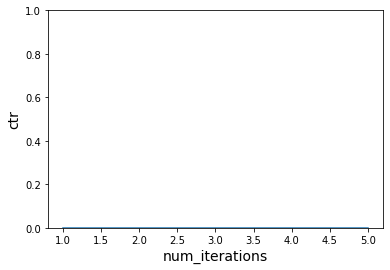

In [ ]:
# Instantiate learner in VW
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)